# Training an RL agent to play super mario
In this notebook, we train an RL agent to learn and play super mario using PPO algorithm

# Install Libraries

In [1]:
!pip install nes-py
!pip install gym-super-mario-bros==7.3.0
!pip install pillow
!pip install ipython
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install gym==0.21.0
!pip install stable-baselines3[extra]==1.6.0


### Restart Kernel

In [3]:
!pip show stable_baselines3
!pip show gym

Name: stable-baselines3
Version: 1.6.0
Summary: Pytorch version of Stable Baselines, implementations of reinforcement learning algorithms.
Home-page: https://github.com/DLR-RM/stable-baselines3
Author: Antonin Raffin
Author-email: antonin.raffin@dlr.de
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, gym, matplotlib, numpy, pandas, torch
Required-by: 
Name: gym
Version: 0.21.0
Summary: Gym: A universal API for reinforcement learning environments.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: jkterry@umd.edu
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, numpy
Required-by: dopamine-rl, nes-py, stable-baselines3


# Play Mario Game Simulation

In [3]:
from nes_py.wrappers import JoypadSpace
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from IPython.display import clear_output, display
from PIL import Image
import numpy as np
env = gym_super_mario_bros.make('SuperMarioBros-v0')
#env = wrappers.Monitor(env, "./gym-results", force=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
before_training = "before_training.mp4"

video = VideoRecorder(env, before_training)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    video.capture_frame()
    state, reward, done, info = env.step(env.action_space.sample())
    # Grab image from env as array
    #img = env.render(mode='rgb_array')

    # Display image with IPython; clear last iPython display on create
    #display(Image.fromarray(np.array(img), 'RGB'), clear=True)
    #env.render()
video.close()
#env.close()

/usr/local/lib/python3.10/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


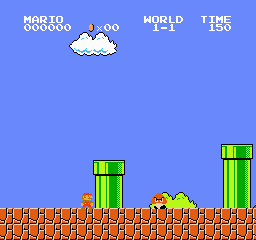

In [4]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from IPython.display import clear_output, display
from PIL import Image
import numpy as np
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    # Grab image from env as array
    img = env.render(mode='rgb_array')

    # Display image with IPython; clear last iPython display on create
    display(Image.fromarray(np.array(img), 'RGB'), clear=True)
    #env.render()

env.close()

In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from IPython.display import clear_output, display
from PIL import Image
import numpy as np

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
done, truncated = True, True
for step in range(100000):

    if done: # or truncated
       env.reset()

    state, reward, done, info = env.step(env.action_space.sample())

    # OR for those who made the switch to gymnasium
    # state, reward, done, truncated, info = env.step(env.action_space.sample())

    # Grab image from env as array
    img = env.render(mode='rgb_array')

    # Display image with IPython; clear last iPython display on create
    display(Image.fromarray(np.array(img), 'RGB'), clear=True)

env.close()

KeyboardInterrupt: ignored

# Setup Environment and Preprocess Mario Environment Frames

In [1]:
#Import FrameStack and GreyScale Wrapper
from gym.wrappers import GrayScaleObservation, FrameStack
from gym.wrappers import ResizeObservation
#Import Vectorization wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
#Import matplotlib
from matplotlib import pyplot as plt



In [2]:
#Debugging Cell - ignore
from nes_py.wrappers import JoypadSpace
#_reset = JoypadSpace.reset

#def reset(self,*args, **kwargs):
    #obs_info = _reset(*args, **kwargs)
    #obs, info = obs_info if type(obs_info) == tuple else (obs_info, {})

#JoypadSpace.reset = reset

In [3]:
#Setup env for applying wrappers and restricting movements
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
from IPython.display import clear_output, display
from PIL import Image
import numpy as np
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)

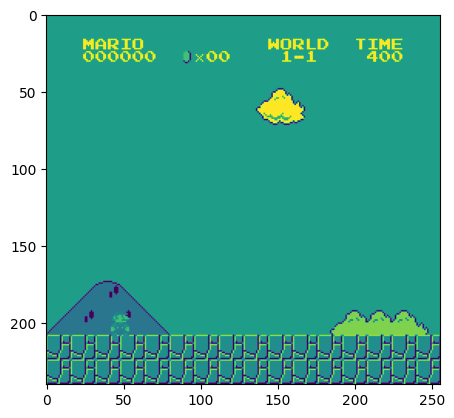

In [4]:
#Example frame after grayscaling
state = env.reset()
plt.imshow(state)

In [5]:
state.shape

(240, 256, 1)

In [6]:
#Add Frame Stack and vectorizer wrapper
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')
state = env.reset()

In [7]:
state = env.reset()
state.shape

(1, 240, 256, 4)

In [8]:
state, reward, done, info = env.step([5])
info

[{'coins': 0,
  'flag_get': False,
  'life': 2,
  'score': 0,
  'stage': 1,
  'status': 'small',
  'time': 400,
  'world': 1,
  'x_pos': 40,
  'x_pos_screen': 40,
  'y_pos': 79}]

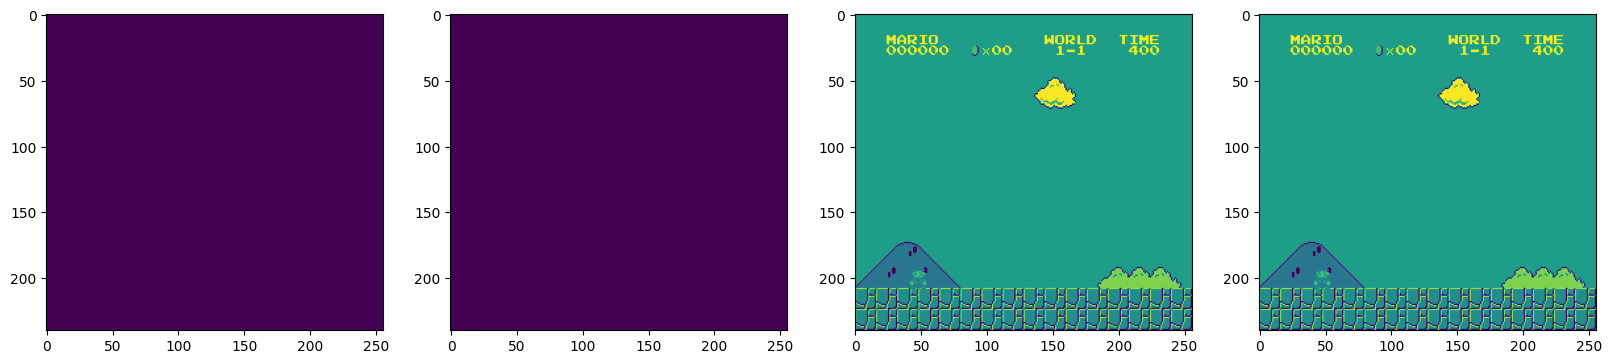

In [9]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
  plt.subplot(1,4,idx+1)
  plt.imshow(state[0][:,:,idx])
plt.show()

# Train RL Model

In [10]:
import os
from stable_baselines3 import PPO # import PPO RL algorithm
from stable_baselines3.common.callbacks import BaseCallback

## Setting Callbacks and save intermediate model while training

In [17]:
class TrainAndLoggingCallback(BaseCallback):
  def __init__(self, check_freq, save_path, verbose=1):
     super(TrainAndLoggingCallback, self).__init__(verbose)
     self.check_freq = check_freq
     self.save_path = save_path

  def _init_callback(self):
     if self.save_path is not None:
      os.makedirs(self.save_path, exist_ok=True)

  def _on_step(self):
    if self.n_calls % self.check_freq == 0:
      model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
      self.model.save(model_path)
    return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=4000000, callback=callback)

Logging to ./logs/PPO_1


/usr/local/lib/python3.10/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 12601        |
|    total_timesteps      | 864768       |
| train/                  |              |
|    approx_kl            | 0.0014604267 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.381       |
|    explained_variance   | 0.892        |
|    learning_rate        | 1e-06        |
|    loss                 | 95.2         |
|    n_updates            | 16880        |
|    policy_gradient_loss | -0.00156     |
|    value_loss           | 240          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 68            |
|    iterations           | 1690          |
|    time_elapsed         | 12609         |
|    total_timesteps      | 865280        |
| train/                  |               |
|    approx_kl            | 0.000643188

KeyboardInterrupt: ignored

> Download Logs and Model Files

In [3]:
from google.colab import files

In [24]:
files.download('/content/logs/PPO_1/events.out.tfevents.1703458660.637013411d95.5272.0')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/train/best_model_1000000.zip')

# Test The new Trained RL agent with PPO Algorithm

In [11]:
model = PPO.load('./train/best_model_1000000', env=env)
model.predict(env.reset())

Wrapping the env in a VecTransposeImage.


(array([4]), None)

> Run the Agent in the Super Mario and see the animation

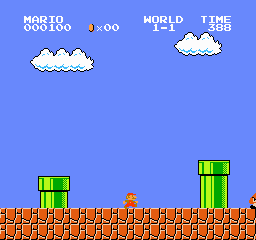

In [ ]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from IPython.display import clear_output, display
from PIL import Image
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder

#env = gym_super_mario_bros.make('SuperMarioBros-v0')
#env = JoypadSpace(env, SIMPLE_MOVEMENT)
done, truncated = True, True
state=env.reset()
rl_trained = "rl_trained_animation.mp4"
video = VideoRecorder(env, rl_trained)
for steps in range(50000):


    #if done: # or truncated
       #state = env.reset()
    video.capture_frame()
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)

    # OR for those who made the switch to gymnasium
    # state, reward, done, truncated, info = env.step(env.action_space.sample())

    # Grab image from env as array
    img = env.render(mode='rgb_array')

    # Display image with IPython; clear last iPython display on create
    display(Image.fromarray(np.array(img), 'RGB'), clear=True)
video.close()
env.close()